In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from pathlib import Path

np.random.seed(715)
tf.random.set_seed(715)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
"""매개변수 (batch_size)로 요청한 만큼 n_steps 길이의 여러 시계열을 만듬
각 시계열에는 타임 스텝마다 하나의 값이 있음(모든 시계열 데이터는 단변량)
이 함수는 [배치 크기, 타임 스텝 수, 1]크기의 넘파이 배열 반환함.
각 시계열은 진폭이 같고 진동 수와 위상이 랜덤한 두 개의 사인 곡선을 더하고 약간의 잡음을 추가함"""
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5*np.sin((time-offsets1) * (freq1 * 10 + 10))    # 사인 곡선 1
    series += 0.2 * np.sin((time-offsets2) * (freq2 * 20 + 20)) # + 사인 곡선 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps +1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000, :n_steps], series[9000:, -1]


Saving figure time_series_plot


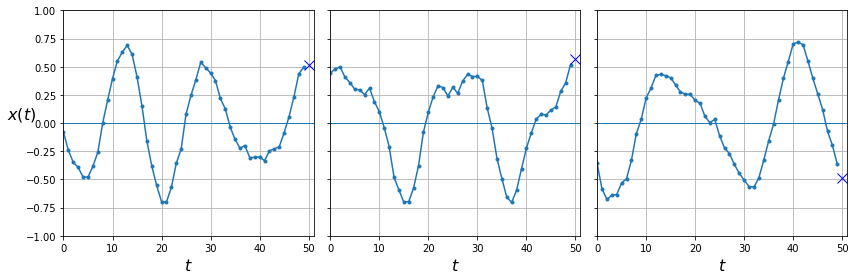

In [4]:
def plot_series(series, y = None, y_pred=None, x_label = "$t$", y_label="$x(t)$"):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bx', markersize = 10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'ro')
    plt.grid(True)

    if x_label:
        plt.xlabel(x_label, fontsize = 16)
    if y_label:
        plt.ylabel(y_label, fontsize = 16, rotation = 0)
    plt.hlines(0, 0, 100, linewidth = 1)
    plt.axis([0, n_steps+1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

In [5]:
print('X_train\n',X_train)
print('y_train\n',y_train)
print(series)
print('series.shape', series.shape)
print('x_train.shape',X_train.shape)
print('y_train.shape', y_train.shape)
print('X_valid.shape', X_valid.shape)
print('y_valid.shape', y_valid.shape)
print('X_pred.shape', X_test.shape)
print('y_pred.shape', y_test.shape)

X_train
 [[[-0.22755246]
  [-0.23364368]
  [-0.1978512 ]
  ...
  [-0.12645307]
  [-0.08566046]
  [-0.0456211 ]]

 [[ 0.52761716]
  [ 0.6013917 ]
  [ 0.57403886]
  ...
  [ 0.40379438]
  [ 0.44495705]
  [ 0.32202315]]

 [[ 0.03916727]
  [ 0.07213228]
  [ 0.10295589]
  ...
  [ 0.2731226 ]
  [ 0.29190657]
  [ 0.2527309 ]]

 ...

 [[ 0.3655712 ]
  [ 0.2968945 ]
  [ 0.25575328]
  ...
  [ 0.5874534 ]
  [ 0.6662398 ]
  [ 0.63316697]]

 [[-0.16542995]
  [-0.15887928]
  [-0.25884596]
  ...
  [-0.08889787]
  [-0.11629082]
  [-0.17836602]]

 [[ 0.5834238 ]
  [ 0.67888016]
  [ 0.7369083 ]
  ...
  [-0.2640541 ]
  [-0.34241897]
  [-0.33429432]]]
y_train
 [[ 0.03157965]
 [ 0.33853206]
 [ 0.31343436]
 ...
 [ 0.4752949 ]
 [-0.2593145 ]
 [-0.39509767]]
[[[-0.22755246]
  [-0.23364368]
  [-0.1978512 ]
  ...
  [-0.08566046]
  [-0.0456211 ]
  [ 0.03157965]]

 [[ 0.52761716]
  [ 0.6013917 ]
  [ 0.57403886]
  ...
  [ 0.44495705]
  [ 0.32202315]
  [ 0.33853206]]

 [[ 0.03916727]
  [ 0.07213228]
  [ 0.10295589]


##### Computing Some Baseline
Naive predictions (just predict the last observed value):

In [6]:
y_pred = X_valid[:,-1]
print(np.mean(keras.losses.mean_squared_error(y_valid, y_pred)))


0.020490464


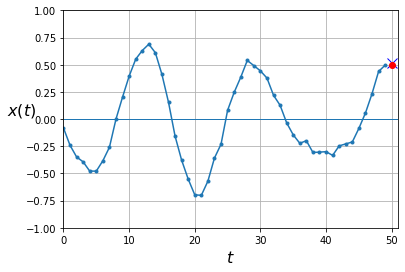

In [7]:
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss= 'mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs = 20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.3072 - val_loss: 0.1782
Epoch 2/20
219/219 [==============================] - 0s 564us/step - loss: 0.1657 - val_loss: 0.1147
Epoch 3/20
219/219 [==============================] - 0s 528us/step - loss: 0.1074 - val_loss: 0.0821
Epoch 4/20
219/219 [==============================] - 0s 551us/step - loss: 0.0837 - val_loss: 0.0704
Epoch 5/20
219/219 [==============================] - 0s 541us/step - loss: 0.0715 - val_loss: 0.0651

In [9]:
model.evaluate(X_valid, y_valid)


63/63 [==============================] - 0s 387us/step - loss: 0.0481


0.04809962213039398

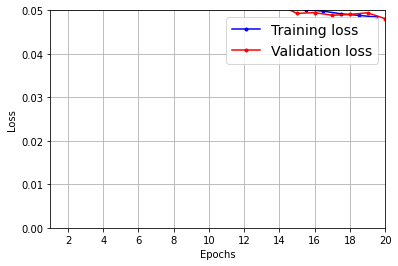

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label = "Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize = 14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

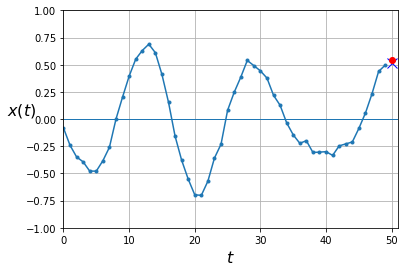

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])
plt.show()

### Using a Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse",optimizer=optimizer)
history=model.fit(X_train, y_train, epochs = 20,
                  validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.1570 - val_loss: 0.0489

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0115


0.011468647047877312

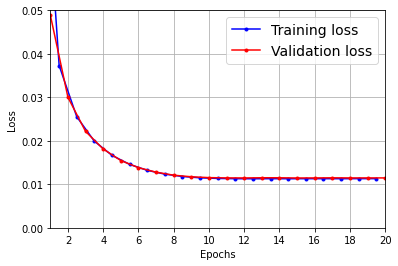

In [14]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

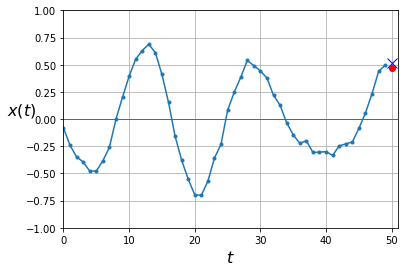

In [15]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])
plt.show()

### Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])


model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs = 20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 14ms/step - loss: 0.1282 - val_loss: 0.0080

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0029


0.002881798427551985

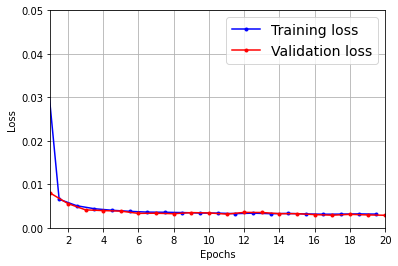

In [18]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

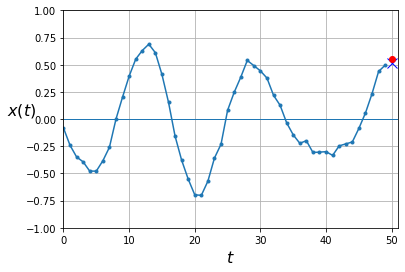

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0, 0])
plt.show()

Make the second SimpleRNN layer return only the last output:


In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs = 20,
                    validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.0532 - val_loss: 0.0049

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0026


0.0026092957705259323

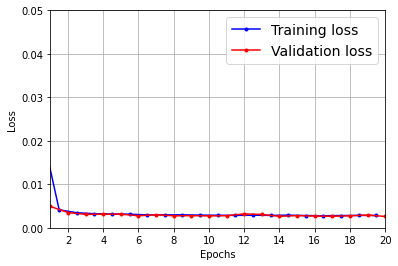

In [22]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

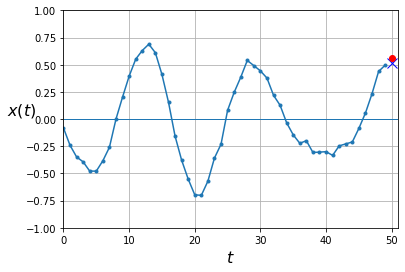

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show()

### Forecasting Several Steps Ahead

아까는 값 1개를 예측했는데, 이제는 10개를 예측함.

In [24]:
np.random.seed(42)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X=X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X= np.concatenate([X, y_pred_one], axis = 1)

Y_pred = X[:, n_steps:]

In [25]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


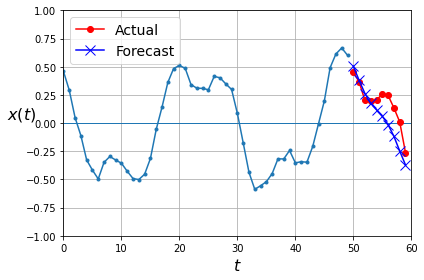

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0,:,0], 'ro-', label='Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0,:,0], 'bx-', label='Forecast', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()


In [27]:
np.random.seed(42)

n_steps=50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

이제 0개의 유닛이 아니나 10개의 유닛을 가진 출력층이 필요

In [28]:
X= X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:,np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis = 1)

Y_pred =X[:, n_steps:, 0]

In [29]:
Y_pred.shape

(2000, 10)

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.035718672

In [31]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 803us/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 560us/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 571us/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 564us/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 560us/step - loss: 0.0300 - val_loss: 0.0283

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.1216 - val_loss: 0.0317

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 +10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]


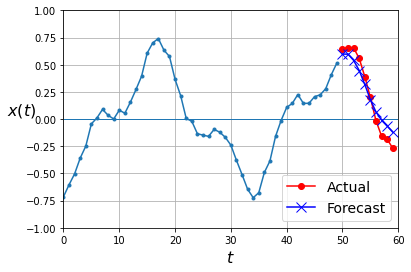

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [36]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y=np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10+1):
    Y[..., step_ahead -1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [37]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324

In [40]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell =keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size = None, dtype = None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype = dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 22ms/step - loss: 0.2892 - last_time_step_mse: 0.2908 - val_loss: 0.0745 - val_last_time_step_mse: 0.0680

### LSTMs

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history=model.fit(X_train, Y_train, epochs= 20,
                  validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 21ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history=model.fit(X_train, Y_train, epochs= 20,
                  validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364